In [ ]:
import re
import pandas as pd
import numpy as np
import scipy.sparse
from scipy.sparse import csr_matrix

import spacy 
import en_core_web_sm


from scipy.cluster.hierarchy import linkage, fcluster ,dendrogram
from scipy.spatial.distance import squareform

from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt    
from matplotlib import cm as cm



# Introduction

In this notebook we exploring the evolution of terms in a given period, to do so we are going to implement in this notebook the approach presented by Lambert Pépin et al in the "Analyse visuelle de la co-évolution des termes dans les thématiques Twitter".

Data used in our case is a chunk of the DBLP database "we will be taking into consideration the papers' titles.

So lets beging .. 

## Importing DBLP DATASET 
#### SELECTING Titles and Years for the last 20 years

In [157]:
df = pd.read_csv("DBLP.csv")
df = df[["Title","Year"]][df['Year']>1999]
df.head()

,Title,Year
3,A characterization of rational D0L power series.,2011.0
7,Equational weighted tree transformations.,2012.0
8,Merged processes: a new condensed representati...,2006.0
9,Verifying a simplification of mutual exclusion...,2013.0
15,Trace- and failure-based semantics for respons...,2014.0


 We will be taking a period of the past 20 years.

## PreProcessing
Our data contains numbers and special characters and some UTF-8 encodings that might interfer with the processing, our data need to be cleaned and tokenized.

 Now and in order to tokenize our data we implement a class tokenizer from spacy and set the different rules for the tokenization 

In [159]:
class MyTokenizer:
    def __init__(self):
        self.lemmatizer = en_core_web_sm.load()
        
    def __call__(self, document):
        res = []
        for t in self.lemmatizer(document):
            if not t.is_stop and not t.is_punct and re.match(r'^[a-zA-ZÀ-ÿ]+$', t.lemma_):
                res.append(t.lemma_)
        return res

In order to retrieve the term frequency we will be using CountVectorizer from sklearn and as a tokenizer that can be passed to our tokenizer as an argument.

For performance purpose We decided to take in count the 1500 most frequent terms by year 

In [160]:
vect = CountVectorizer(tokenizer = MyTokenizer(),max_features=1500)

### Building the features vectors and the vocabulary 

In the following blocks we implement the method purposed for the construction of the feature vectors. 

For each word we will have a dictionary where the word is the key and the value is a feature vector of 20 values containing the frequency of the term in each year of the 20 past years.


In [161]:
#Vocabulary element
def get_elt(w):
    return {
         w :
         [0] * 20
    }

The function below allow us to build our vocabulary of terms and feature vectors.

For each year we buil a Document Term Matrix that will be summed on the documents axis retrieving the frequency of each term.

Then new terms will be added to the vocabulary.

Finally the value of the current year of each term will be set to the current frequency.



In [204]:
import pickle
def get_vocabulary(vect,p=20):
    vocabulary = {}
    for i in range(p):
        year = 2019 - i
        print("year :",year)
        df_year = df[df['Year'] == year]
        dtm = vect.fit_transform(df_year['Title'])
        freqs = np.squeeze(np.asarray(np.sum(dtm.todense(), axis = 0)))
        words = vect.get_feature_names()
        for k,v in zip(words,freqs):
            if (k in vocabulary.keys()):
                vocabulary[k][i] = v
            else :
                w = get_elt(k)
                w[k][i] = v
                vocabulary.update(w)
    import _pickle as pickle

    with open('vocabulary.txt'+str(p), 'wb') as file:
         file.write(pickle.dumps(vocabulary)) # use `pickle.loads` to do the reverse
    return vocabulary


In [163]:
vocabulary = get_vocabulary(vect)

year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010
year : 2009
year : 2008
year : 2007
year : 2006
year : 2005
year : 2004
year : 2003
year : 2002
year : 2001
year : 2000


Now that we have our vocabulary and our feature vectors lets implement the similarity function.

First we implrmrnt a method that will return the number of coordination between two vectors.

In [164]:
def get_coord(a,b):
    n = 0
    for i in range(len(a)):
        for j in range(len(a)):
            if (a[i] >= b[i] and a[j] >= b[j]) or (a[i] <= b[i] and a[j] <= b[j]) :
                n = n + 1                
    return (n,len(a)*len(a)-n)


Next and from the previous function we use the Nc and Nd values to calculate the Kendall score. 

![](kendall.png)

In [165]:
def kendall(v1,v2,n):
    Nc,Nd = get_coord(v1,v2)
    return ((Nc-Nd) / ((.5 * n)*(n-1)))


Now we build out Matrix based on the kendall score.

![](mat.png)

In [166]:
def get_coo_evolution(vocab,vocabulary,p):
    n = len(vocabulary)
    flags = [False] * p
    mat = []
    for i,v in enumerate(vocab):
        row = []
        for j,w in enumerate(vocab):
            if(j < i):
                row.append(mat[j][i])
            else :
                row.append(kendall(v,w,p))
        mat.append(row)
        if i % 200 == 0:
            a = float("{0:.2f}".format((i/n)*100))
            print("Processed {} / {} : {} %".format(i,n,a))
            
    return csr_matrix(mat)
            

In [168]:
vectors  = np.array(list(vocabulary.values()))
coo_evolution = scipy.sparse.load_npz('coo_evolution2.npz')
#coo_evolution = get_coo_evolution(vectors,vocabulary,20)
type(coo_evolution)
 
scipy.sparse.save_npz('coo_evolution2.npz',coo_evolution) # use `pickle.loads` to do the reverse



Processed 0 / 3920 : 0.0 %
Processed 200 / 3920 : 5.1 %
Processed 400 / 3920 : 10.2 %
Processed 600 / 3920 : 15.31 %
Processed 800 / 3920 : 20.41 %
Processed 1000 / 3920 : 25.51 %
Processed 1200 / 3920 : 30.61 %
Processed 1400 / 3920 : 35.71 %
Processed 1600 / 3920 : 40.82 %
Processed 1800 / 3920 : 45.92 %
Processed 2000 / 3920 : 51.02 %
Processed 2200 / 3920 : 56.12 %
Processed 2400 / 3920 : 61.22 %
Processed 2600 / 3920 : 66.33 %
Processed 2800 / 3920 : 71.43 %
Processed 3000 / 3920 : 76.53 %
Processed 3200 / 3920 : 81.63 %
Processed 3400 / 3920 : 86.73 %
Processed 3600 / 3920 : 91.84 %
Processed 3800 / 3920 : 96.94 %


In [170]:
coev = coo_evolution.todense()
max_sim = np.max(coev)
max_sim

2.1052631578947367

Now lets visualize our matrix

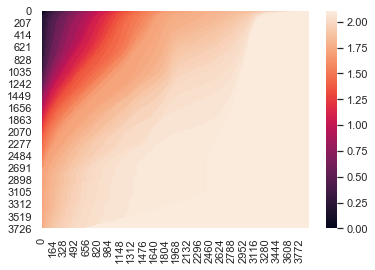

In [262]:
import seaborn as sns; sns.set()
coev.sort(axis=1)
coev.sort(axis=0)
ax = sns.heatmap(coev)

In order to perform classification we need to transform similarity to dissimilarity 

and to do so we will substract the max from all the values of our matrix in that way the more similar word will have the less distance between them.

And right then we perform Hierarchical clustering

In [244]:
dissimilarity = max_sim - np.abs(coo_evolution.todense())
hierarchy = linkage(squareform(dissimilarity), method='complete')
labels = fcluster(hierarchy, 0.5, criterion='distance')

In [245]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
    
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

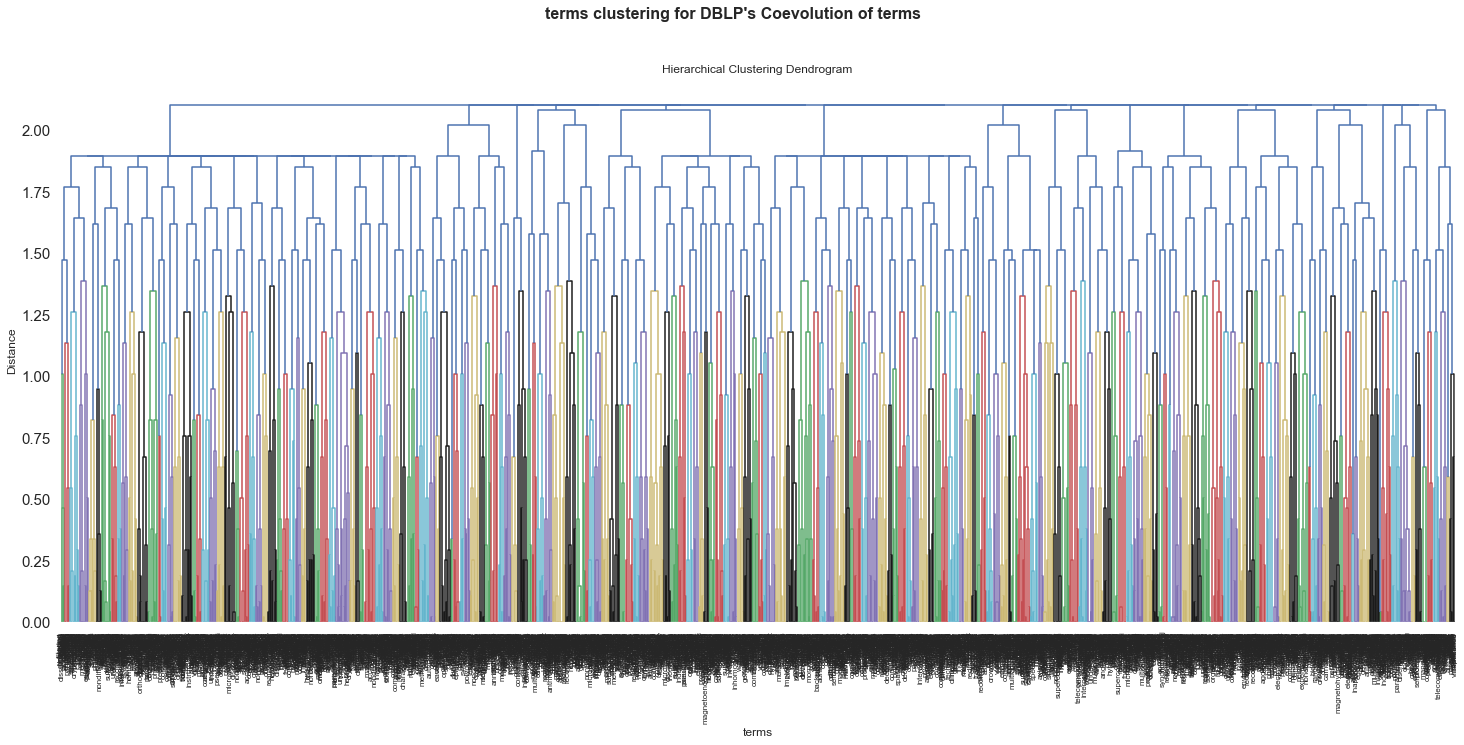

In [246]:

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
B =dendrogram(
    hierarchy,
    labels=np.array(list(vocabulary.keys())),
    #leaf_rotation=90.,  # rotates the x axis labels
    #leaf_font_size=8.,  # font size for the x axis labels
)
ax=plt.gca()
ax.tick_params(axis='x', which='major', labelsize=8)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.xlabel("terms")
    #plt.set_size_inches(18.5, 10.5)
plt.ylabel('Distance')
plt.suptitle("terms"+" clustering for DBLP's Coevolution of terms ", fontweight='bold', 
             fontsize=16);
plt.show()

In [208]:
get_cluster_classes(B)

{'g': ['filtering',
  'notation',
  'dimension',
  'dominant',
  'dissemination',
  'expect',
  'phone',
  'thyroid',
  'long',
  'organic',
  'noise',
  'scanner',
  'viscosity',
  'dimension',
  'algebraic',
  'landmark',
  'plasticity',
  'direction',
  'honeypot',
  'electronic',
  'vote',
  'modulator',
  'decode',
  'lossy',
  'standard',
  'dae',
  'electricity',
  'square',
  'bump',
  'canonical',
  'support',
  'hypercube',
  'gps',
  'canonical',
  'deformation',
  'subsequence',
  'n',
  'entry',
  'family',
  'convective',
  'interior',
  'easy',
  'bifurcation',
  'vhdl',
  'similarity',
  'rethink',
  'ring',
  'computerized',
  'isomorphism',
  'underwater',
  'calculate',
  'loading',
  'jog',
  'window',
  'circulant',
  'unknown',
  'proneness',
  'salesman',
  'transaction',
  'monster',
  'volume',
  'successive',
  'relevant',
  'ilu',
  'phenomenon',
  'retrieve',
  'like',
  'objectivity',
  'laplace',
  'neumann',
  'volume',
  'like',
  'ilu',
  'determine',
  'dan',
  'minimum',
  'tune',
  'year',
  'terrorism',
  'visualization',
  'sigmoidal',
  'government',
  'saccular',
  'rural',
  'r',
  'intuition',
  'decouple',
  'neurofuzzy',
  'intelligence',
  'viewpoint',
  'nonsymmetric',
  'logical',
  'structurally',
  'human',
  'structuralist',
  'pi',
  'film',
  'uniquely',
  'advanced',
  'droplet',
  'discontinuity',
  'topological',
  'monotonic',
  'novel',
  'l',
  'water',
  'telecom',
  'preventive',
  'luman',
  'prior',
  'machining',
  'l',
  'entropy',
  'identical',
  'difference',
  'era',
  'talk',
  'accelerated',
  'shadow',
  'delivery',
  'coincidence',
  'davidson',
  'perturbation',
  'satisfy',
  'potential',
  'restoration',
  'superposition',
  'pseudo',
  'quarterly',
  'relation',
  'bluetooth',
  'lambda',
  'realization',
  'rbac',
  'usability',
  'prospect',
  'framework',
  'prologue',
  'prediction',
  'innovative',
  'framework',
  'positivity',
  'angiogram',
  'pair',
  'screening',
  'assistant',
  'literature',
  'spoof',
  'fuzzy',
  'quantifi',
  'interpolation',
  'south',
  'fuzzy',
  'minimization',
  'mosfet',
  'program',
  'border',
  'super',
  'ubiquitous',
  'usable',
  'engineering',
  'interstate',
  'interactive',
  'subjective',
  'streaming',
  'improved',
  'thesauri',
  'substrate',
  'return',
  'integration',
  'variety',
  'making',
  'canadian',
  'modal',
  'dg',
  'differencing',
  'teacher',
  'variational',
  'repetitive',
  'tool',
  'missile',
  'strongly',
  'criterion',
  'minkowski',
  'wall',
  'pilot',
  'wear',
  'pressure',
  'selfish',
  'compensation',
  'owl',
  'platform',
  'compound',
  'function',
  'pyramid',
  'lab',
  'leakage',
  'recovery',
  'star',
  'enhance',
  'invertible',
  'tradeoff',
  'vertex',
  'checker',
  'write',
  'multiblock',
  'inference',
  'multi',
  'adversarial',
  'bandpass',
  'resonator',
  'sparsity',
  'bearing',
  'car',
  'deblurring',
  'topic',
  'bisector',
  'vessel',
  'groupware',
  'controller',
  'guess',
  'home',
  'dirichlet',
  'regularize',
  'hardness',
  'text',
  'stroke',
  'resilient',
  'mine',
  'par',
  'survey',
  'immediate',
  'synchronous',
  'airy',
  'toeplitz',
  'enumeration',
  'cost',
  'inflow',
  'reversible',
  'section',
  'merging',
  'set',
  'proving',
  'geometrical',
  'multiscale',
  'handling',
  'upwind',
  'release',
  'cartesian',
  'pse',
  'mpc',
  'particle',
  'iii',
  'barrier',
  'periodicity',
  'boltzmann',
  'subthreshold',
  'probe',
  'timing',
  'uav',
  'algorithmic',
  'basal',
  'multiplicative',
  'reaction',
  'pivoting',
  'polyhedral',
  'regularization',
  'ethic',
  'transform',
  'nonholonomic',
  'person',
  'obfuscation',
  'leverage',
  'station',
  'sensitive',
  'geo',
  'unmanned',
  'empirical',
  'insecurity',
  'dissipation',
  'formation',
  'president',
  'collective',
  'compressor',
  'assist',
  'riemannian',
  'bullet',
  'extreme',
  'mutually',
  'inverse',
  'macro',
  'communication',
  'marine',
  '

Now lets see if using TfIdf Tokenization improves the results

In [178]:
vect2 = TfidfVectorizer(tokenizer = MyTokenizer(),max_features=1000)
#vocabulary2 = get_vocabulary(vect2)
vocabulary2 = pickle.load( open( "vocabulary2.txt", "rb" ) )
len(vocabulary2)

year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010
year : 2009
year : 2008
year : 2007
year : 2006
year : 2005
year : 2004
year : 2003
year : 2002
year : 2001
year : 2000


2372

In [180]:
vectors2  = np.array(list(vocabulary2.values()))
coo_evolution2 = get_coo_evolution(vectors2,vocabulary2,20)
coev2 = coo_evolution2.todense()
max_sim = np.max(coev2)
max_sim

Processed 0 / 2372 : 0.0 %
Processed 200 / 2372 : 8.43 %
Processed 400 / 2372 : 16.86 %
Processed 600 / 2372 : 25.3 %
Processed 800 / 2372 : 33.73 %
Processed 1000 / 2372 : 42.16 %
Processed 1200 / 2372 : 50.59 %
Processed 1400 / 2372 : 59.02 %
Processed 1600 / 2372 : 67.45 %
Processed 1800 / 2372 : 75.89 %
Processed 2000 / 2372 : 84.32 %
Processed 2200 / 2372 : 92.75 %


2.1052631578947367

In [279]:
coev2.sort(axis=1)
coev2.sort(axis=0)
coev2
dissimilarity2 = max_sim - np.abs(coo_evolution2.todense())

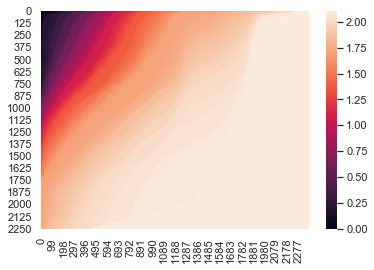

In [280]:
ax = sns.heatmap(coev2)

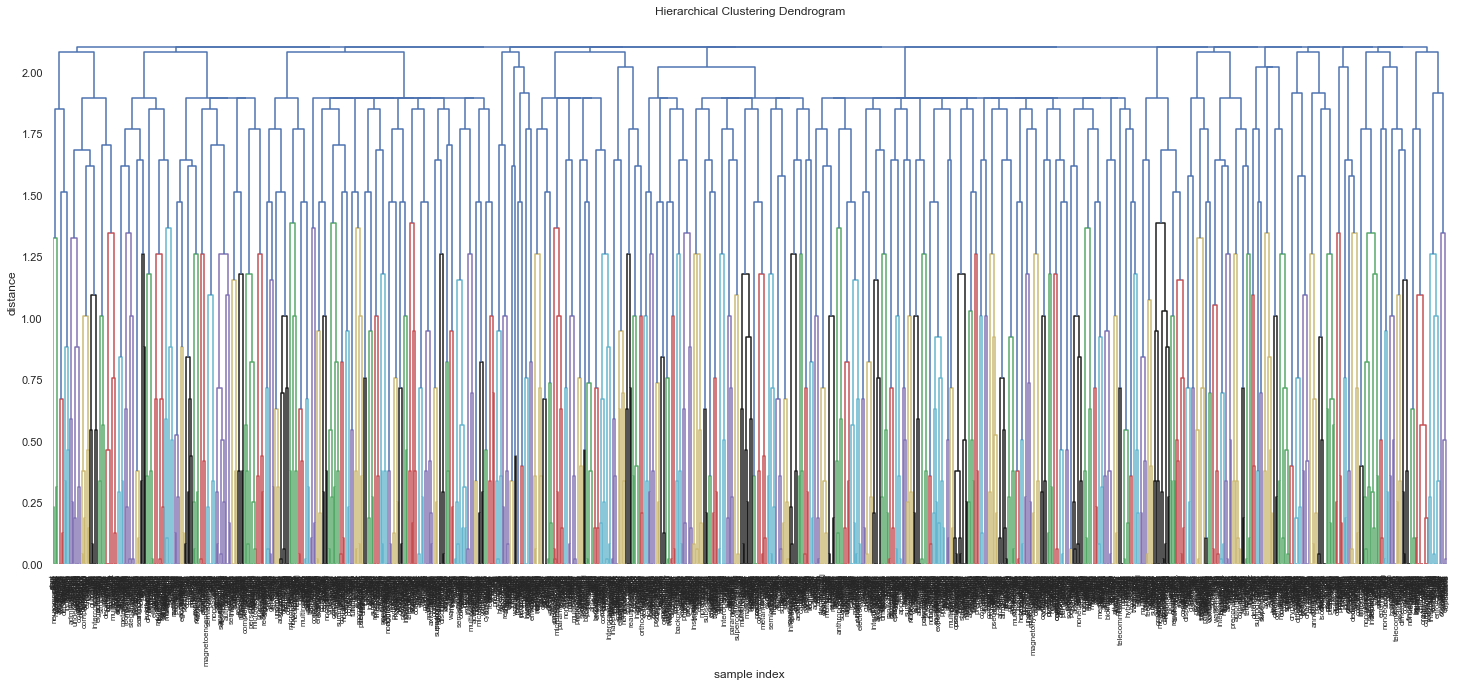

{'g': ['sms',
  'shot',
  'neuromorphic',
  'dead',
  'turn',
  'gyrokinetic',
  'hypermedia',
  'electrode',
  'synthesize',
  'session',
  'fir',
  'electrode',
  'eigenfunction',
  'latch',
  'sketch',
  'structurally',
  'mind',
  'kind',
  'safer',
  'lambda',
  'resistive',
  'wright',
  'thesis',
  'vortex',
  'dss',
  'isogeometric',
  'cryptographic',
  'bifurcation',
  'affective',
  'socio',
  'convective',
  'perceptron',
  'clinical',
  'modified',
  'ader',
  'silico',
  'purchase',
  'professor',
  'rt',
  'teacher',
  'monster',
  'sar',
  'explanatory',
  'lax',
  'computerized',
  'nonoscillatory',
  'brief',
  'radiographic',
  'lag',
  'configurable',
  'obsolete',
  'complementarity',
  'voyager',
  'office',
  'viewpoint',
  'marketing',
  'say',
  'limitation',
  'membrane',
  'np',
  'personalization',
  'logarithm',
  'progress',
  'reusability',
  'o',
  'rayleigh',
  'logarithmic',
  'hermitian',
  'leftist',
  'microelectronic',
  'electron',
  'prepared',
  'microprocessor',
  'shadow',
  'dsp',
  'coronary',
  'nonconvergent',
  'wafer',
  'expect',
  'neuroscience',
  'adequacy',
  'mib',
  'photonic',
  'helicopter',
  'letter',
  'tradeoff',
  'slow',
  'unbounded',
  'si',
  'budget',
  'bipartite',
  'decennial',
  'pareto',
  'left',
  'elementary',
  'hair',
  'seismic',
  'medial',
  'commitment',
  'synchronize',
  'lightwave',
  'multiplier',
  'kármán',
  'gaas',
  'summarization',
  'multiplier',
  'white',
  'sage',
  'example',
  'kingdom',
  'interleave',
  'align',
  'ghost',
  'urn',
  'encoding',
  'texturing',
  'laguerre',
  'example',
  'conquer',
  'evoke',
  'phylogenetic',
  'conductive',
  'grating',
  'authenticate',
  'inconsistency',
  'bankruptcy',
  'fragment',
  'rna',
  'inconsistency',
  'prognostic',
  'admission',
  'conjugacy',
  'specify',
  'davidson',
  'nested',
  'push',
  'inexact',
  'soc',
  'subclass',
  'suitable',
  'cybersecurity',
  'reflect',
  'subdivision',
  'bayes',
  'disaster',
  'gauss',
  'ultrasound',
  'domino',
  'alternate',
  'strip',
  'amplitude',
  'openmath',
  'format',
  'successive',
  'history',
  'rmi',
  'transparent',
  'burger',
  'history',
  'hip',
  'optimistic',
  'parametrize',
  'sequent',
  'silicon',
  'book',
  'truncation',
  'scan',
  'trade',
  'xml',
  'annotation',
  'wire',
  'ranking',
  'insensitive',
  'asset',
  'paperwork',
  'collective',
  'cyclic',
  'gaze',
  'helix',
  'entity',
  'injection',
  'international',
  'electro',
  'implication',
  'presentation',
  'f',
  'man',
  'maintainability',
  'magnetostatic',
  'customization',
  'bgk',
  'xenakis',
  'saturate',
  'modularity',
  'riccati',
  'deneste',
  'doctoral',
  'encapsulate',
  'bottleneck',
  'pathwidth',
  'waste',
  'narrative',
  'packing',
  'cuda',
  'bring',
  'predictability',
  'packing',
  'aerodynamic',
  'roger',
  'gmre',
  'quotient',
  'categorical',
  'majority',
  'resistivity',
  'www',
  'holonic',
  'seamless',
  'repertory',
  'represent',
  'stepwise',
  'stencil',
  'anthropomorphic',
  'recycle',
  'reveal',
  'learner',
  'localized',
  'jessica',
  'sustainability',
  'minnesota',
  'cardinal',
  'particulate',
  'vast',
  'depository',
  'unsymmetric',
  'pencil',
  'existential',
  'excitatory',
  'guard',
  'japanese',
  'adjoint',
  'involve',
  'fill',
  'rely',
  'depository',
  'stop',
  'assistant',
  'linearized',
  'polis',
  'cassirer',
  'polygonization',
  'aeroacoustic',
  'uniquely',
  'prioritization',
  'sorted',
  'singularly',
  'éditorial',
  'linearized',
  'prioritization',
  'rectangle',
  'novice',
  'nodal',
  'agentization',
  'expressive',
  'valuation',
  'null',
  'century',
  'singularity',
  'plagiarism',
  'intellectual',
  'century',
  'living',
  'breathe',
  'varying',
  'census',
  'necessary',
  'hull',
  'uml',
  'neurofuzzy',
  'contour',
  'formalize',
  'competition',
  'multicomputer',
  'relevant',
  'varying',
  'crosstalk',
  'organ',
  'dynamically',
  'precedence'

In [209]:

hierarchy2 = linkage(squareform(dissimilarity2), method='complete')
labels2 = fcluster(hierarchy2, 0.2, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
A = dendrogram(
    hierarchy2,
    p=10,
    labels=np.array(list(vocabulary.keys())),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
get_cluster_classes(A)

  ### lets try a smaller period ex 10years

For a large period as 20 years the arrival of new words will interfer with the study of the coevolution of terms so in order to have a more segnificant study lets use the dta for the last past 10 years

In [210]:
df2 = df[["Title","Year"]][df['Year']>2009]
df2['Year'].value_counts()

2017.0    11227
2016.0     9592
2018.0     9491
2015.0     8698
2014.0     8399
2013.0     8064
2012.0     6828
2011.0     6614
2010.0     6444
2019.0       39
Name: Year, dtype: int64

In [211]:
vocabulary3=get_vocabulary(vect,10)
vocabulary3 = pickle.load( open( "vocabulary2.txt", "rb" ) )


year : 2019
year : 2018
year : 2017
year : 2016
year : 2015
year : 2014
year : 2013
year : 2012
year : 2011
year : 2010


In [ ]:
vectors3  = np.array(list(vocabulary3.values()))
coo_evolution3 = get_coo_evolution(vectors3,vocabulary3,10)
coev3 = coo_evolution3.todense()
max_sim3 = np.max(coev3)
coev3.shape
len(coev3)


Processed 0 / 158 : 0.0 %


158

we can see that our vocabulary reduced considerably 

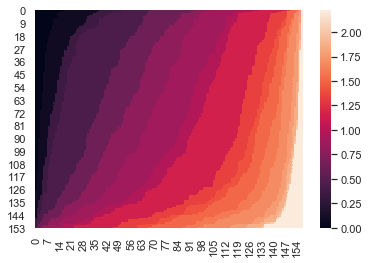

In [282]:
ax = sns.heatmap(coev3)

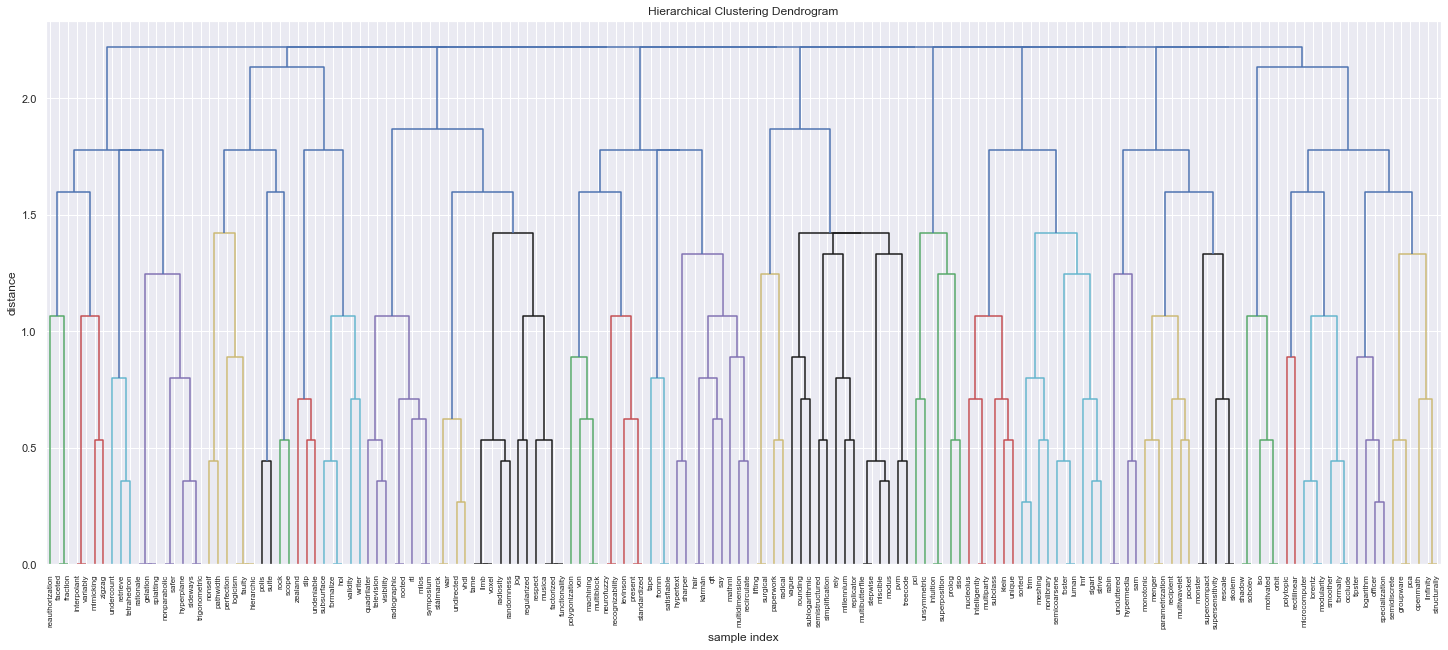

g,"['faceted', 'fraction', 'reauthorization', 'rock', 'scope', 'machining', 'multiblock', 'von', 'polygonization', 'pci', 'unsymmetric', 'intuition', 'superposition', 'prolog', 'siso', 'shadow', 'sobolev', 'motivated', 'orbit', 'iso']"
r,"['interpolant', 'variably', 'mimicking', 'zigzag', 'slip', 'undeniable', 'zealand', 'neurofuzzy', 'recognizability', 'present', 'standardized', 'levinson', 'intelligently', 'multiparty', 'nucleolus', 'klein', 'unique', 'subclass', 'polytopic', 'rectilinear']"
c,"['retrieve', 'tetrahedron', 'undercount', 'formalize', 'hol', 'subsurface', 'validity', 'writer', 'fromm', 'satisfiable', 'tape', 'sorted', 'trim', 'meshing', 'nonlibrary', 'foster', 'luman', 'semicoarsene', 'sigart', 'strive', 'lmf', 'lorentz', 'modularity', 'microcomputer', 'formally', 'occlude', 'smoother']"
m,"['gelation', 'splatting', 'rationale', 'nonparabolic', 'safer', 'sideways', 'trigonometric', 'hyperplane', 'television', 'visibility', 'quadrilater', 'radiographic', 'rooted', 'milos', 'symposium', 'rtl', 'hypertext', 'sharper', 'hair', 'kármán', 'qft', 'say', 'multidimension', 'recirculate', 'mathml', 'rabin', 'uncluttered', 'hypermedia', 'sam', 'officer', 'specialization', 'logarithm', 'tipster']"
y,"['nonself', 'pathwidth', 'faulty', 'hierarchic', 'logicism', 'perfection', 'stålmarck', 'war', 'undirected', 'vhdl', 'lifting', 'surgical', 'paperwork', 'radical', 'menger', 'parametrization', 'monotonic', 'multiwavelet', 'pocket', 'recipient', 'groupware', 'pca', 'semidiscrete', 'linfinity', 'structurally', 'openmath']"
k,"['polis', 'suite', 'limb', 'voxel', 'tame', 'radiosity', 'randomness', 'jog', 'regularized', 'factorized', 'functionality', 'musica', 'respect', 'rounding', 'sublogarithmic', 'vague', 'semistructured', 'simplification', 'millennium', 'replicator', 'rely', 'multibutterflie', 'stepwise', 'miscible', 'modus', 'pvm', 'treecode', 'modus', 'monster', 'supercompact', 'rescale', 'skolem', 'supersensitivity']"
b,['intuition']


In [283]:
dissimilarity3 = max_sim3 - np.abs(coo_evolution3.todense())
hierarchy3 = linkage(squareform(dissimilarity3), method='complete')
labels3 = fcluster(hierarchy3, 0.2, criterion='distance')

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
C = dendrogram(
    hierarchy3,
    labels=np.array(list(vocabulary.keys())),
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
get_cluster_classes(C)

Now if we take as example the magenta cluster we find for example  :
trigonometric hyperplane multidimension logarithm ect that might be linked to the same topics.